**ML PROBLEM 5.1**

In [1]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import os
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
import keras
from keras import *

In [2]:
X_train = np.load(os.path.abspath('Xtrain_Classification1.npy'))
y_train = np.load(os.path.abspath('ytrain_Classification1.npy'))
X_test  = np.load(os.path.abspath('Xtest_Classification1.npy'))

prof da cadeira diz pa usar transfer learning


podemos só usar classificadores do sklearn tipo mlpclassifier, logistic regression, naive bayes, svm

balanced accuracy: (sensitivity + setificity)/2
sensitivity= True positive/(true positvity + false negativity)
setificity = (true negative)/(true neg + false positive)


Use pytorch neural network - harder but most usefull for harder problems (other options are jax and keras)
output layer - 2 neurons is a classification problem - use softmax (if it was 1 neuron it would be regression)



**Neural Network**


In [34]:
def data_augmentation(x, y):
    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])
    
    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma

    #choosing to augment only the underrepresented class of data
    if difference >0:           
        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment
    
    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)

    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])

    #generating data
    i=0
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=1, seed=1000): 

        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(1,2352))])
        y_augmented = np.vstack([y_augmented, batch_y])
        i += 1
        if i > difference:
            break
    
    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])

    return balanced_x, balanced_y


In [36]:
balanced_x, balanced_y = data_augmentation(X_train,y_train)

(5754, 28, 28, 3) (5754, 2) (500, 28, 28, 3) (500, 2)
Epoch 1/30
45/45 [==============================] - 4s 63ms/step - loss: 0.6923 - precision_2: 0.8403 - recall_2: 0.8403 - val_loss: 0.3729 - val_precision_2: 0.8460 - val_recall_2: 0.8460
Epoch 2/30
45/45 [==============================] - 3s 59ms/step - loss: 0.3515 - precision_2: 0.8577 - recall_2: 0.8577 - val_loss: 0.3477 - val_precision_2: 0.8460 - val_recall_2: 0.8460
Epoch 3/30
45/45 [==============================] - 3s 58ms/step - loss: 0.3331 - precision_2: 0.8577 - recall_2: 0.8577 - val_loss: 0.3428 - val_precision_2: 0.8460 - val_recall_2: 0.8460
Epoch 4/30
45/45 [==============================] - 3s 59ms/step - loss: 0.3234 - precision_2: 0.8578 - recall_2: 0.8578 - val_loss: 0.3698 - val_precision_2: 0.8480 - val_recall_2: 0.8480
Epoch 5/30
45/45 [==============================] - 3s 60ms/step - loss: 0.3278 - precision_2: 0.8601 - recall_2: 0.8601 - val_loss: 0.3485 - val_precision_2: 0.8500 - val_recall_2: 0.8500
E

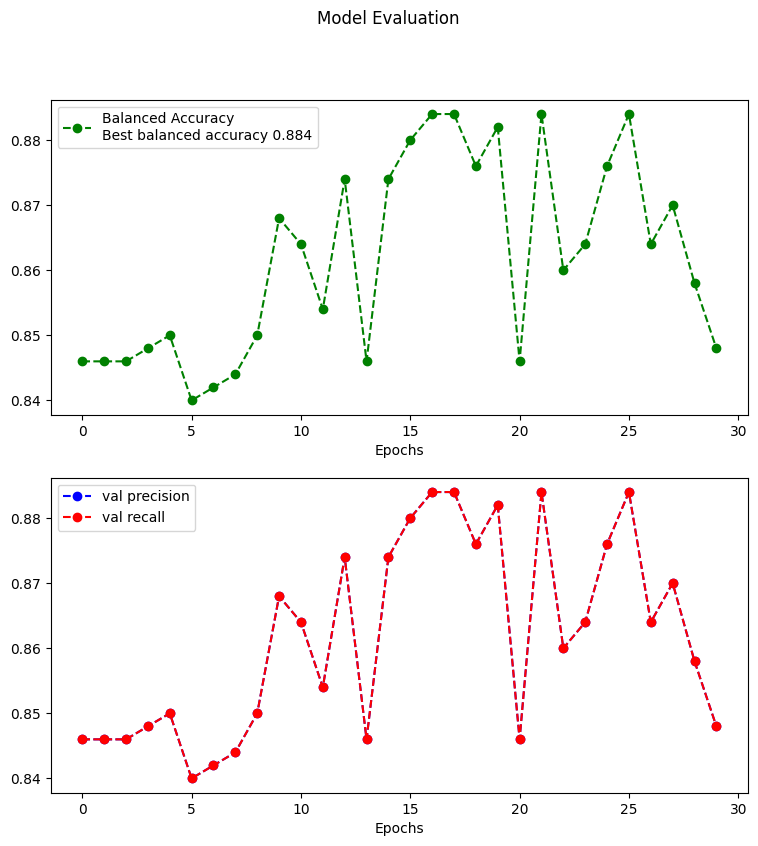

In [48]:
#run all functions before this

model2, model_history2 = neural_defandTrain("adam", "binary_crossentropy" ,30,128,3,3, balanced_x, balanced_y)


In [49]:

def neural_defandTrain(optimizer_string, loss_string ,epoch_nr,batch,nrconvlayers, nrdesnelayers, x_all, y_all):

    X_train_sample, y_train_sample, X_validation, y_validation = x_y_preprocessing(x_all, y_all)

    model = model_def(optimizer_string, loss_string, nrconvlayers, nrdesnelayers)

    model_history = model.fit(
        X_train_sample,
        y_train_sample,
        batch_size=batch,
        epochs=epoch_nr,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        validation_data=(X_validation, y_validation)
    )
    best_balancedAccuracy = plot_neuralmodel(model_history)
    
    save_model(model, model_history, optimizer_string, loss_string ,epoch_nr,batch, best_balancedAccuracy, nrconvlayers, nrdesnelayers)

    return model, model_history


In [4]:
### Neural Network
def model_def(optimizer_string, loss_string, nrconvlayers, nrdesnelayers):
    model_img= keras.Sequential()
    model_img.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3)))
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))
    for i in range(nrconvlayers-1):
        model_img.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

    #we do not need to use a maxpooling layer after each convolution layer, but it helps reducing computacional load
    if nrconvlayers>4:
        model_img.add(layers.MaxPooling2D(pool_size=(2, 2))) #if we have to many conv layers - a maxpooling is adequado

    model_img.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))     #for simple image convolution 2-4 conv layers should be enougth. The number of filters in 
    model_img.add(layers.MaxPooling2D(pool_size=(2, 2)))                        #each layer should start with 32-64 and increase with deeper layers, which enables the CNN to learn more abstract patterns
    
    #dense layers
    model_img.add(layers.Flatten())
    model_img.add(layers.Dense(256, activation='relu'))
    for i in range(nrdesnelayers-1):
        model_img.add(layers.Dense(64, activation='relu'))
    model_img.add(layers.Dense(2, activation='softmax'))
    

    model_img.compile(
            optimizer = optimizer_string,
            # Optimizer: use either ADAM or SGDM
            # Loss function to minimize
            loss = loss_string,
            # List of metrics to monitor
            metrics=[keras.metrics.Precision(),keras.metrics.Recall()]
        )

    return model_img



In [46]:

def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy, nrconvlayers, nrdesnelayers ):
    
    #define names for the files
    file_name_model=f"bestbacc_{best_balancedAccuracy}  layers_{nrconvlayers}_{nrdesnelayers}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    #model_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_model)
    file_name_history=f"bestbacc_{best_balancedAccuracy}  layers_{nrconvlayers}_{nrdesnelayers}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    #history_path=Path(r'C:\Users\alexa\OneDrive - Universidade de Lisboa\4º Ano\1º Semestre - MEEC\Aprendizagem Automática\Labs2\ML_Aaut',file_name_history)

    #save the model in a .keras file
    model_fitted.save(file_name_model)
    #save history to numpy array
    np.save(file_name_history,model_history.history)
   

In [6]:
def plot_neuralmodel(model):
    dtf = pd.DataFrame(model.history)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,9))
    fig.suptitle('Model Evaluation')

    best_bacc =round(max((dtf.iloc[:,4]+dtf.iloc[:,5])/2),4)
   

    ax1.plot((dtf.iloc[:,4]+dtf.iloc[:,5])/2,'go--',label=f'Balanced Accuracy\nBest balanced accuracy {best_bacc}')
    
    ax1.legend()
    ax1.set_xlabel('Epochs')

    ax2.plot(dtf.iloc[:,4],'bo--',label='val precision')
    ax2.plot(dtf.iloc[:,5],'ro--',label='val recall')
    ax2.legend()
    ax2.set_xlabel('Epochs')

    plt.show()
    return best_bacc


In [42]:
def x_y_preprocessing(x,y):
    X_train_img = np.reshape(X_train,(X_train.shape[0],28,28,3)).copy()
    X_val, X_train_sample = X_train_img[:500].copy(), X_train_img[500:].copy()
    y_val, y_train_sample = y_train[:500].copy(), y_train[500:].copy()


    y_train_2labels = keras.utils.to_categorical(y_train_sample, num_classes=2)
    y_val_2labels = keras.utils.to_categorical(y_val, num_classes=2)
    
    
    return X_train_sample, y_train_2labels, X_val, y_val_2labels

